In [ ]:
# Standard libraries
import numpy as np
import json
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.utils import to_categorical
import seaborn as sns
from google.colab import drive
import os
# Mount Google Drive for access
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# Load data from JSON files
with open('/content/drive/MyDrive/My-207/X_train_n.json', 'r') as file:
    X_train = json.load(file)

with open('/content/drive/MyDrive/My-207/y_train_n.json', 'r') as file:
    y_train = json.load(file)

with open('/content/drive/MyDrive/My-207/X_val_n.json', 'r') as file:
    X_val = json.load(file)

with open('/content/drive/MyDrive/My-207/y_val_n.json', 'r') as file:
    y_val = json.load(file)

In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert labels to integers
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# Convert integer labels to one-hot encoded labels
y_train_hot = to_categorical(y_train_encoded)
y_val_hot = to_categorical(y_val_encoded)






In [ ]:
print(X_train.shape)
print(X_val.shape)

(7889, 20, 157)
(3121, 20, 157)


In [ ]:


train_X_reshape = X_train.reshape(-1, 20*157)
val_X_reshape = X_val.reshape(-1, 20*157)

scaler = MinMaxScaler((0,1)).fit(train_X_reshape)

train_X_scaled = scaler.transform(train_X_reshape)
val_X_scaled = scaler.transform(val_X_reshape)

X_train = train_X_scaled.reshape(-1,20,157)
X_val = val_X_scaled.reshape(-1,20,157)

print(X_train.shape)
print(X_val.shape)




(7889, 20, 157)
(3121, 20, 157)


In [ ]:
# swap the x and y axis so doing convolution on the time dimension
train_X_perm = []
for each in X_train:
  train_X_perm.append(np.transpose(each))

X_train = np.array(train_X_perm)

val_X_perm = []
for each in X_val:
  val_X_perm.append(np.transpose(each))

X_val = np.array(val_X_perm)

print(X_train.shape)
print(X_val.shape)

(7889, 157, 20)
(3121, 157, 20)


In [ ]:
num_classes = np.unique(y_train_encoded).shape[0]
# Define the model
model = models.Sequential()
model.add(layers.GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
model.add(layers.GRU(32, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [ ]:
# Early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Train the model
history = model.fit(X_train, y_train_hot, epochs=20, batch_size=32, validation_data=(X_val, y_val_hot), callbacks=[es])






Epoch 1/20
247/247 [==============================] - 53s 199ms/step - loss: 1.4112 - accuracy: 0.4485 - val_loss: 1.1174 - val_accuracy: 0.4941
Epoch 2/20
247/247 [==============================] - 47s 191ms/step - loss: 1.0201 - accuracy: 0.5600 - val_loss: 1.0513 - val_accuracy: 0.5037
Epoch 3/20
247/247 [==============================] - 47s 189ms/step - loss: 1.0452 - accuracy: 0.5072 - val_loss: 1.1294 - val_accuracy: 0.3909
Epoch 4/20
247/247 [==============================] - 46s 185ms/step - loss: 1.0385 - accuracy: 0.5319 - val_loss: 1.0625 - val_accuracy: 0.5293
Epoch 5/20
247/247 [==============================] - 47s 190ms/step - loss: 0.9661 - accuracy: 0.5727 - val_loss: 1.2769 - val_accuracy: 0.4088
Epoch 6/20
247/247 [==============================] - 49s 197ms/step - loss: 0.9269 - accuracy: 0.5974 - val_loss: 0.9778 - val_accuracy: 0.5559
Epoch 7/20
247/247 [==============================] - 46s 187ms/step - loss: 0.9219 - accuracy: 0.6007 - val_loss: 0.9624 - val_ac

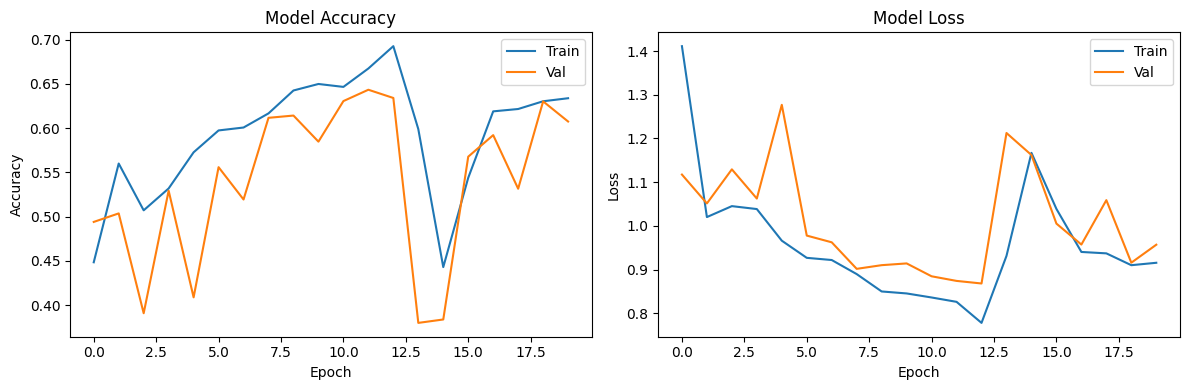

98/98 [==============================] - 3s 35ms/step
Classification Report:
               precision    recall  f1-score   support

      barswa       0.60      0.69      0.64      1056
      comsan       0.98      0.42      0.59       972
     eaywag1       0.51      0.69      0.59      1093

    accuracy                           0.61      3121
   macro avg       0.70      0.60      0.61      3121
weighted avg       0.69      0.61      0.61      3121



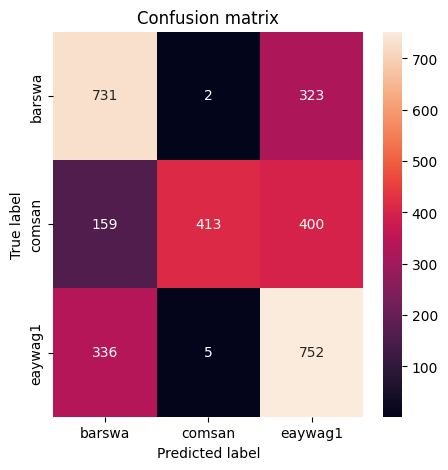

In [ ]:

# Plot training history
import seaborn as sns
from sklearn.metrics import classification_report
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])

plt.tight_layout()
plt.show()

from numpy import argmax

# Reverse one-hot encoding
y_val_argmax = argmax(y_val_hot, axis=1)

# Generate predictions
y_pred_prob = model.predict(X_val)
y_pred = y_pred_prob.argmax(axis=1)  # get class with highest probability for each sample

# Generate classification report
print("Classification Report:\n", classification_report(y_val_argmax, y_pred, target_names=encoder.classes_))

# Generate confusion matrix
cm = confusion_matrix(y_val_argmax, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, xticklabels=encoder.classes_, yticklabels=encoder.classes_, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()